Forest Emissions Tracking - Phase I
===================================

<img src="https://carbonplan-assets.s3.amazonaws.com/images/social/homepage.png" alt="CarbonPlan" width="400" style="float:right"/>

_by Joe Hamman and Jeremy Freeman (CarbonPlan)_

March 29, 2020

## Introduction
In general, greenhouse gasses (GHGs) arising from forest land use changes can be attributed to both natural factors (e.g. wildfire) and human activities (e.g. deforestation). Our approach is to build upon an existing body of research that has provided high-resolution satellite-based estimates of aboveground biomass (Spawn et al., 2020), forest cover change (Hansen et al., 2013), and change attribution (Curtis et al., 2018). While many of the necessary data products already exist, we can integrate, extend, or update these resources to provide global, current estimates that can be integrated with the other resources produced by the coalition.

Specifically, for any given spatial extent and time duration ($t1$ to $t2$), we can use three quantities — existing biomass, forest cover change, and change attribution — to estimate the effective GHG emissions from land use changes. The simplest estimate is:

$\Delta Biomass (t) = TotalBiomass (t) * \Delta ForestCover (\%)$

$Emissions (tCO_2) = \Delta Biomass (t) * 0.5 (tC/t) * 3.67 (tC02 / tC)$

where $\Delta ForestCover$ is the fraction of pixels within the given spatial extent that experienced a stand-replacement disturbance between $t1$ and $t2$. The $TotalBiomass$ is estimated as the aboveground biomass at time $t1$. This estimate can be further refined by attributing, for each pixel, the source of forest cover loss (e.g. wildfire, deforestation, etc.), and using those sources to express emissions fractionally and/or exclude certain categories from total estimates (e.g. rotational clear-cutting within tree plantations). Pixel-wise estimates can then be aggregated into province and country-wide estimates.

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import intake
import xarray as xr
from dask.distributed import Client

from data import open_hansen_2018_tile

# TODO: switch to carbonplan style theme
plt.rcParams["font.family"] = "monospace"

# data catalog
cat = intake.open_catalog('catalog.yaml')

TC02_PER_TC = 3.67
TC_PER_TBM = 0.5

In [3]:
# start a local Dask cluster
client = Client()
display(client)

/usr/local/lib/python3.7/site-packages/distributed/client.py:1122: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| dask    | 2.4.0  | 2.4.0     | 2.17.0  |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://127.0.0.1:53979 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [8]:
# open a single 10x10 tile of data
lat = '10S'
lon = '070W'
box = dict(lat=slice(-11.25, -11.75), lon=slice(-63.75, -63.25))

ds = open_hansen_2018_tile(lat, lon)
display(ds)

<xarray.Dataset>
Dimensions:        (band: 4, lat: 40000, lon: 40000)
Coordinates:
  * lat            (lat) float64 -10.0 -10.0 -10.0 -10.0 ... -20.0 -20.0 -20.0
  * lon            (lon) float64 -70.0 -70.0 -70.0 -70.0 ... -60.0 -60.0 -60.0
  * band           (band) int64 1 2 3 4
Data variables:
    treecover2000  (lat, lon) float64 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    gain           (lat, lon) uint8 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    lossyear       (lat, lon) uint16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    datamask       (lat, lon) uint8 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    first          (band, lat, lon) uint8 dask.array<chunksize=(4, 4000, 4000), meta=np.ndarray>
    last           (band, lat, lon) uint8 dask.array<chunksize=(4, 4000, 4000), meta=np.ndarray>
    agb            (lat, lon) int16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    emissions_ha   (lat, lon) int16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    emissions_px   (lat, lon) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>

In [9]:
# calculate d_treecover
years = xr.DataArray(range(2001, 2019), dims=('year', ), name='year')
loss_frac = []
for year in years:
    loss_frac.append(xr.where((ds['lossyear'] == year), ds['treecover2000'], 0))
ds['d_treecover'] = xr.concat(loss_frac, dim=years)
display(ds)

<xarray.Dataset>
Dimensions:        (band: 4, lat: 40000, lon: 40000, year: 18)
Coordinates:
  * lat            (lat) float64 -10.0 -10.0 -10.0 -10.0 ... -20.0 -20.0 -20.0
  * lon            (lon) float64 -70.0 -70.0 -70.0 -70.0 ... -60.0 -60.0 -60.0
  * band           (band) int64 1 2 3 4
  * year           (year) int64 2001 2002 2003 2004 2005 ... 2015 2016 2017 2018
Data variables:
    treecover2000  (lat, lon) float64 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    gain           (lat, lon) uint8 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    lossyear       (lat, lon) uint16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    datamask       (lat, lon) uint8 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    first          (band, lat, lon) uint8 dask.array<chunksize=(4, 4000, 4000), meta=np.ndarray>
    last           (band, lat, lon) uint8 dask.array<chunksize=(4, 4000, 4000), meta=np.ndarray>
    agb            (lat, lon) int16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    emissions_ha   (lat, lon) int16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    emissions_px   (lat, lon) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    d_treecover    (year, lat, lon) float64 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>

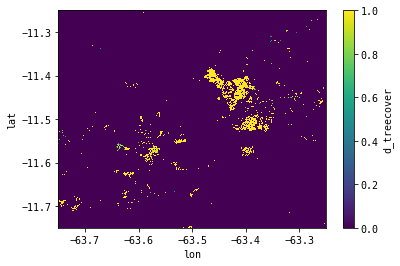

In [10]:
ds['d_treecover'].sum('year').sel(**box).plot()

In [11]:
def calc_emissions(ds):
    d_biomass = ds['agb'] * ds['d_treecover']
    emissions = d_biomass * TC_PER_TBM * TC02_PER_TC
    return emissions

In [12]:
ds['emissions'] = calc_emissions(ds)
display(ds['emissions'])

<xarray.DataArray 'emissions' (lat: 40000, lon: 40000, year: 18)>
dask.array<mul, shape=(40000, 40000, 18), dtype=float64, chunksize=(4000, 4000, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -10.0 -10.0 -10.0 -10.0 ... -20.0 -20.0 -20.0 -20.0
  * lon      (lon) float64 -70.0 -70.0 -70.0 -70.0 ... -60.0 -60.0 -60.0 -60.0
  * year     (year) int64 2001 2002 2003 2004 2005 ... 2014 2015 2016 2017 2018

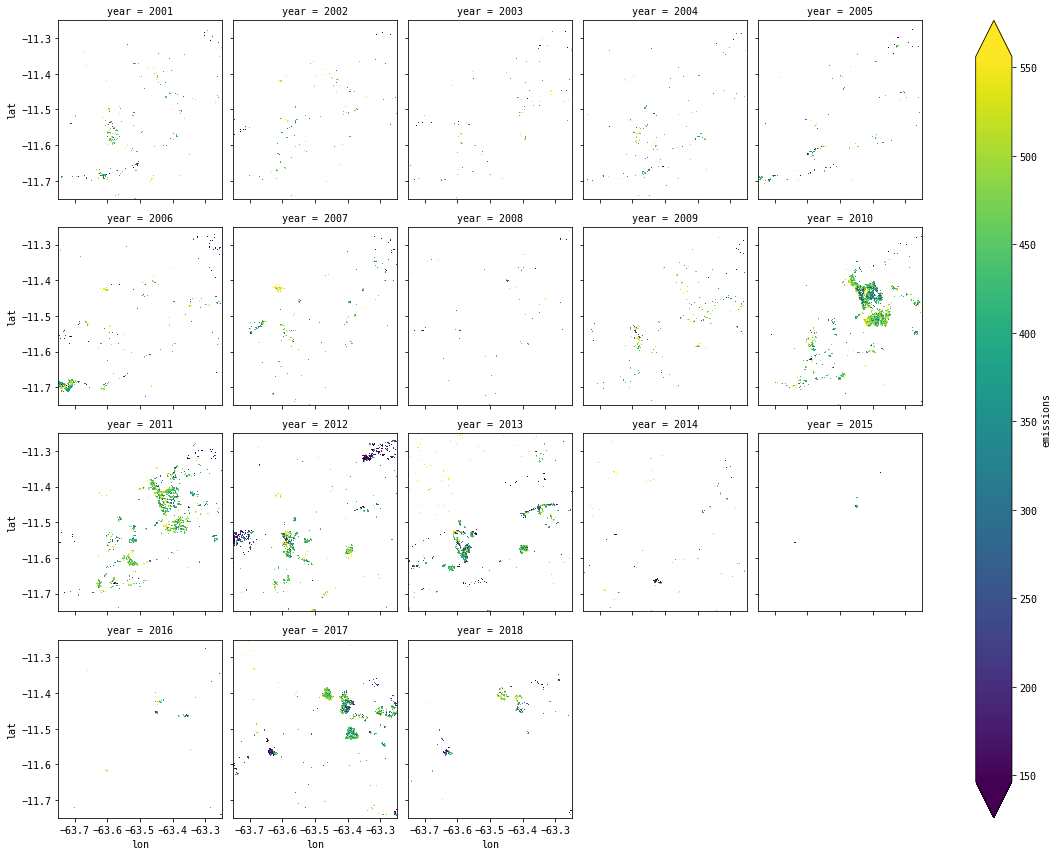

In [13]:
temp = ds['emissions'].sel(**box)
temp = temp.where(temp).persist()
temp.plot(col='year', col_wrap=5, robust=True)

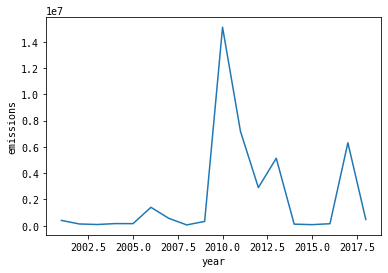

In [14]:
# todo, need to adjust units (currently summing units of tco2/ha)
temp.sum(('lat', 'lon')).plot()

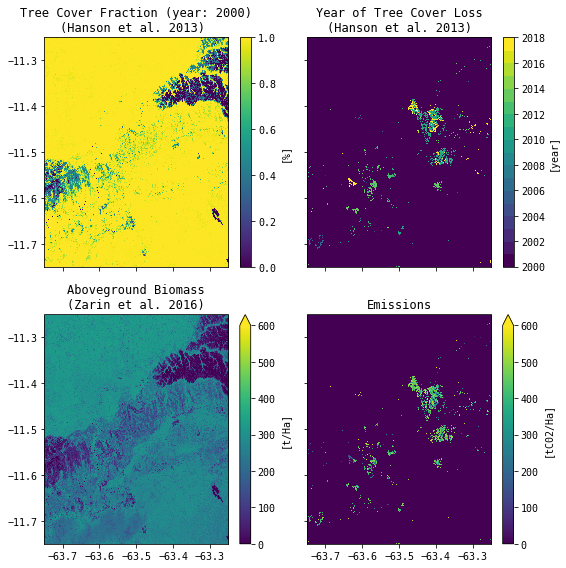

In [10]:
ds['emissions_tot'] = ds['emissions'].sum('year')
variables = ['treecover2000', 'lossyear', 'agb', 'emissions_tot']
titles = ['Tree Cover Fraction (year: 2000)\n(Hanson et al. 2013) ', 'Year of Tree Cover Loss\n(Hanson et al. 2013)', 'Aboveground Biomass\n(Zarin et al. 2016)', 'Emissions']
units = ['[%]', '[year]', '[t/Ha]', '[tC02/Ha]']

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8, 8))

ds_plot = ds.sel(**box).persist()

kwargs = {}
for i, var in enumerate(variables):
    ax = axes.flat[i]
    if i >= 2:
        kwargs = dict(vmin=0, vmax=600, extend='max')
    if i == 1:
        kwargs = dict(vmin=2000, vmax=2018, levels=19)
    da = ds_plot[var]
    da.plot.imshow(ax=ax, add_labels=False, cbar_kwargs={'label': units[i]}, **kwargs)
    ax.set_title(titles[i])

fig.tight_layout()

In [15]:
# jeremy, you can pick up here. 
ds_ornl = cat.ornl_biomass.to_dask()

(-50, 1250)

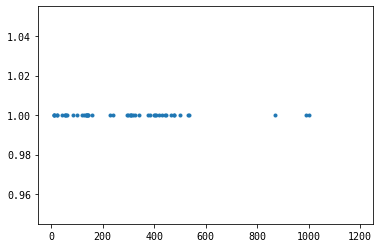

In [25]:
from pandas import read_csv

df = read_csv('FIA-biomass-by-state.csv')
plt.plot(df['biomass'], df['biomass'] * 0 + 1, '.')
plt.xlim([-50, 1250])

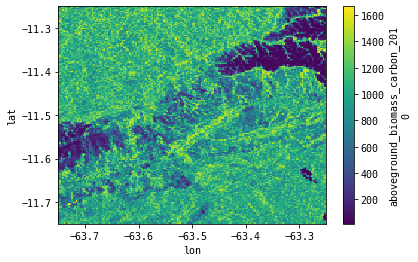

In [12]:
ds_ornl['aboveground_biomass_carbon_2010'].sel(**box).plot()

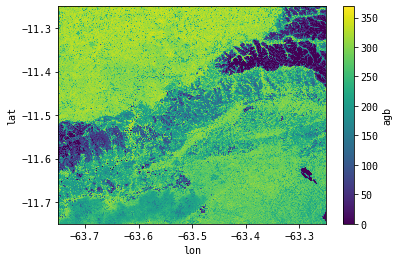

In [13]:
ds['agb'].sel(**box).plot()